In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

In [2]:
ds = datasets.fetch_covtype()

In [5]:
ds.target.shape

(581012,)

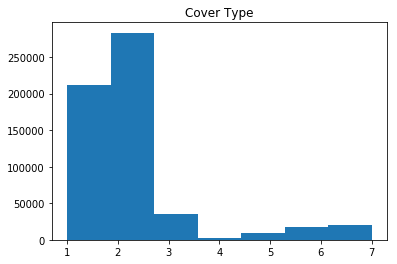

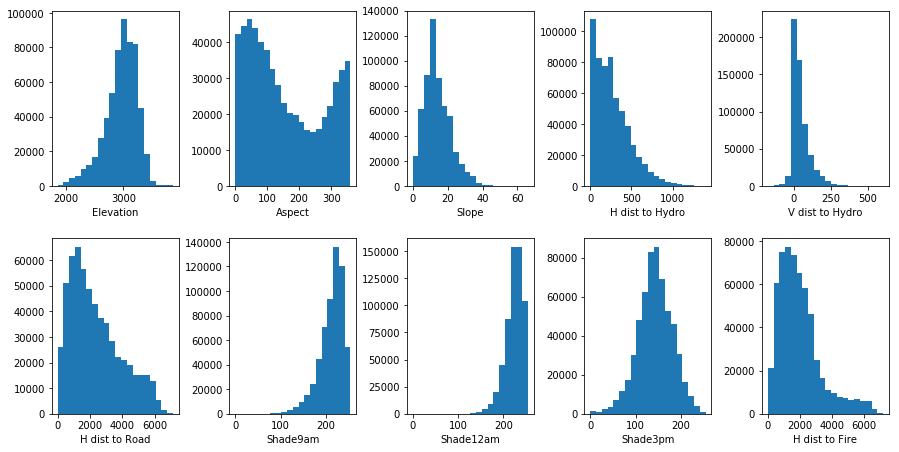

In [3]:
# TASK 2.1
feature_names = ["Elevation", "Aspect", "Slope", "H dist to Hydro", "V dist to Hydro", "H dist to Road", 
                 "Shade9am", "Shade12am", "Shade3pm", "H dist to Fire"]
plt.hist(ds.target, bins=7)
plt.title("Cover Type")

fig, axs = plt.subplots(2,5)
fig.set_size_inches(15, 8)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

counter = 0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].hist(ds.data[:,counter], bins=20)
        axs[i,j].set_xlabel(feature_names[counter])
        counter+=1

plt.show()

In [ ]:
#Task 2.2
from timeit import default_timer as timer

X_train, X_test, y_train, y_test = train_test_split(ds.data, ds.target, test_size=0.4, random_state=0)

scores = []

clf = linear_model.LogisticRegression(multi_class='multinomial', tol=.01, solver='sag')
scores.append(cross_val_score(clf, X_train, y_train))

clf = LinearSVC(multi_class='ovr', tol=.01, dual=False)
scores.append(cross_val_score(clf, X_train, y_train))

clf = NearestCentroid()
scores.append(cross_val_score(clf, X_train, y_train))


# Repeat the above with scaled training data
scores_scaled = []
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

clf = linear_model.LogisticRegression(multi_class='multinomial', tol=.01, solver='sag', n_jobs=2)
scores_scaled.append(cross_val_score(clf, X_train_scaled, y_train))
logit = clf.fit(X_train_scaled, y_train)

clf = LinearSVC(multi_class='ovr', tol=.01, dual=False)
scores_scaled.append(cross_val_score(clf, X_train_scaled, y_train))
svc = clf.fit(X_train_scaled, y_train)

clf = NearestCentroid()
scores_scaled.append(cross_val_score(clf, X_train_scaled, y_train))
centroid = clf.fit(X_train_scaled, y_train)

# print CV results
trunc = lambda x: ['{:.3f}'.format(e) for e in x] 
print("{:12s} | {:^25s} | {:^25s} | {:^25s} ".format(" ", "Logistic Reg", "Linear SVC", "Nearest Centroid"))
print(''.join(['-'] * 90))
print("{:12s}   {:^20s}   {:^20s}   {:^20s}".format(*list(["R^2"] + [trunc(e).__str__() for e in scores])))
print("{:12s}   {:^20s}   {:^20s}   {:^20s}".format(*list(["R^2 (Scaled)"] + [trunc(e).__str__() for e in scores_scaled])))

In [113]:
# TASK 2.3 
res = []
  
    # Logistic Regression GridSearch
param_grid = {'multi_class': ['ovr', 'multinomial'],
              'C': np.logspace(-2, 2, 5)
             }
clf_grid = GridSearchCV(linear_model.LogisticRegression(tol=.01, solver='sag', n_jobs=2), param_grid)
clf_grid.fit(X_train_scaled, y_train)
logit_res = pd.DataFrame(clf_grid.cv_results_)
logit_best = clf_grid.best_estimator_
    
    # LinearSVC GridSearch
param_grid = {'C': np.logspace(-2, 2, 10)}
clf_grid = GridSearchCV(LinearSVC(tol=.01, dual=False), param_grid)
clf_grid.fit(X_train_scaled, y_train)
svc_res = pd.DataFrame(clf_grid.cv_results_)
svc_best = clf_grid.best_estimator_

    # Nearest Centroid GridSearch
param_grid = {'shrink_threshold': np.logspace(0, 2, 10),
              'metric': ["euclidean", "manhattan"]
             }
clf_grid = GridSearchCV(NearestCentroid(), param_grid)
clf_grid.fit(X_train_scaled, y_train)
centroid_res = pd.DataFrame(clf_grid.cv_results_)
centroid_best = clf_grid.best_estimator_


####### PLOT results ######

# Plot nearest centroid grid search results

res = centroid_res
fig, ax = plt.subplots(1,1)
fig.suptitle("Nearest Centroid Grid Search Results", fontsize=16)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top = 0.85, bottom=0.2, hspace=0.3, wspace=0.4)

ax.errorbar(res['param_shrink_threshold'][:10], res['mean_test_score'][:10], 
    yerr=res['std_test_score'][:10], fmt='-o', capsize=5, label='Euclidean')

ax.set_xscale('log')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Shrink Threshold")

ax.errorbar(res['param_shrink_threshold'][10:20], res['mean_test_score'][10:20], 
    yerr=res['std_test_score'][10:20], fmt='-o', capsize=5, label='Manhattan')

plt.legend()


# Plot logistic reg grid search results
res = logit_res
fig, ax = plt.subplots(1,1)
fig.suptitle("Logistic Regression Grid Search Results", fontsize=16)
fig.set_size_inches(5,5)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

evens = [2*i for i in range(0,5)]
odds = [2*i + 1 for i in range(0,5)]

ax.errorbar([res['param_C'][i] for i in odds], [res['mean_test_score'][i] for i in odds], 
    yerr=[res['std_test_score'][i] for i in odds], fmt='-o', capsize=5, label='Multinomial')
ax.errorbar([res['param_C'][i] for i in evens], [res['mean_test_score'][i] for i in evens], 
    yerr=[res['std_test_score'][i] for i in evens], fmt='-ro', capsize=5, label='One vs rest')
ax.set_xscale('log')
ax.set_ylabel("Accuracy")
ax.set_xlabel("C")
          
plt.legend()
plt.show()


# Plot Linear SVC grid search results
res = svc_res
fig, ax = plt.subplots(1,1)
fig.suptitle("Linear SVC Grid Search Results", fontsize=16)
fig.set_size_inches(5,5)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

ax.errorbar(res['param_C'], res['mean_test_score'], 
    yerr=res['std_test_score'], fmt='-o', capsize=5)
ax.set_xscale('log')
ax.set_ylabel("Accuracy")
ax.set_xlabel("C")
plt.show()

In [184]:
# TASK 2.4
    
# Logistic Regression GridSearch
param_grid = {'multi_class': ['ovr', 'multinomial'],
              'C': np.logspace(-2, 2, 5)
             }
clf_grid = GridSearchCV(linear_model.LogisticRegression(tol=.01, solver='sag', n_jobs=2), param_grid, cv=KFold(shuffle=True))
clf_grid.fit(X_train_scaled, y_train)
logit_res_shuffle = pd.DataFrame(clf_grid.cv_results_)
logit_best_shuffle = clf_grid.best_estimator_
    
# LinearSVC GridSearch
param_grid = {'C': np.logspace(-2, 2, 10)}
clf_grid = GridSearchCV(LinearSVC(tol=.01, dual=False), param_grid, cv=KFold(shuffle=True))
clf_grid.fit(X_train_scaled, y_train)
svc_res_shuffle = pd.DataFrame(clf_grid.cv_results_)
svc_best_shuffle = clf_grid.best_estimator_

# Nearest Centroid GridSearch
param_grid = {'shrink_threshold': np.logspace(0, 2, 10),
              'metric': ["euclidean", "manhattan"]
             }
clf_grid = GridSearchCV(NearestCentroid(), param_grid, cv=KFold(shuffle=True))
clf_grid.fit(X_train_scaled, y_train)
centroid_res_shuffle = pd.DataFrame(clf_grid.cv_results_)
centroid_best_shuffle = clf_grid.best_estimator_

print("Logistic Regression parameters with Stratified KFold\n")
print(logit_best.get_params())

print("\nLogistic Regression parameters with shuffling\n")
print(logit_best_shuffle.get_params())

print("\n\nLinear SVC parameters with Stratified KFold\n")
print(svc_best.get_params())

print("\nLinear SVC parameters with shuffling\n")
print(svc_best_shuffle.get_params())

print("\n\nNearest Centroid parameters with Stratified KFold\n")
print(centroid_best.get_params())

print("\n\nNearest Centroid parameters with shuffling\n")
print(centroid_best_shuffle.get_params())

Logistic Regression parameters with Stratified KFold
{'C': 100.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': 2, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.01, 'verbose': 0, 'warm_start': False}


Logistic Regression parameters with shuffling
{'C': 100.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': 2, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.01, 'verbose': 0, 'warm_start': False}
Linear SVC parameters with Stratified KFold
{'C': 1.6681005372000592, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.01, 'verbose': 0}


Linear SVC parameters with shuffling
{'C': 35.938136638046259, 'class_weight': None, 'dual

In [171]:
# TASK 2.5

print("Coefficients of Best Logistic Regression\nEach class has different coefficients, so they are showed in a tabular manner\n")
print('{:4s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} '.format("Coef","Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"))
print(''.join(['-'] * 85))

for i in range(0, len(logit_best.coef_[0])):
    vals = [i]
    for j in range(0, 7):
        vals.append(logit_best.coef_[j][i])
    print('{:3d}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.2f}'.format(*vals))

    

print("\n\nCoefficients of Best Linear SVC \nEach class has different coefficients, so they are showed in a tabular manner\n")
print('{:4s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} | {:8s} '.format("Coef","Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"))
print(''.join(['-'] * 85))

for i in range(0, len(svc_best.coef_[0])):
    vals = [i]
    for j in range(0, 7):
        vals.append(logit_best.coef_[j][i])
    print('{:3d}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.3f}    {:^7.2f}'.format(*vals))

#### COEFFICIENTS ARE THE SAME FOR BOTH MODELS !!!! #####
    

Coefficients of Best Logistic Regression
Each class has different coefficients, so they are showed in a tabular manner

Coef | Class 1  | Class 2  | Class 3  | Class 4  | Class 5  | Class 6  | Class 7  
-------------------------------------------------------------------------------------
  0     2.632      0.325     -3.148     -2.198     -0.515     -2.964      5.87  
  1    -0.177     -0.150      0.171     -0.002      0.248      0.033      -0.12 
  2     0.052      0.142      0.203     -0.096      0.153     -0.334      -0.12 
  3    -0.170      0.226      0.758     -0.515     -0.032      0.256      -0.52 
  4    -0.155     -0.091      0.079      0.178      0.217     -0.004      -0.22 
  5    -0.135      0.005      0.209      0.564     -0.735      0.384      -0.29 
  6    -0.029     -0.289     -0.148      0.319      0.243      0.040      -0.13 
  7    -0.412      0.356      0.245      0.334      0.157     -0.471      -0.21 
  8     0.432     -0.136     -0.245     -0.223     -0.152      